In [110]:
#loading the libraries
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import rpy2

In [112]:
#defining the class MDN
class MDN_module(tf.keras.Model):

    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        x=self.h2(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [113]:
no_parameters=3
components=1
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    #print(alpha)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def eval_mdn_model_mle(x_test,y_test):
        indices_1 = [i for i, x in enumerate(x_test) if x == 1]
        indices_0 = [i for i, x in enumerate(x_test) if x == 0]
        mu_0=np.mean(y_test[indices_0])
        mu_1=np.mean(y_test[indices_1])
        sigma_0=np.std(y_test[indices_0])
        sigma_1=np.std(y_test[indices_1])
        y_mean=np.zeros((len(y_test),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        y_std=np.zeros((len(y_test),1))
        y_std[indices_1]=sigma_1
        y_std[indices_0]=sigma_0
        alpha=np.ones((len(y_mean),1))
        return gnll_eval(y_test,alpha,y_mean,y_std).numpy()
    
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [4]:
def compute_loss(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        #return np.array(nlcor.nlcor(P,Q)[0])[0]
        return eval_mdn_model(P,Q,mdn_PQ)
    else:
        return eval_mdn_model_mle(P,Q)
        
        
        


In [5]:
def compute_loss_y_pred(P,Q,mle=False):
    """ Compute the loss for the given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
        return y_pred[:,1]
    else:
        indices_1 = [i for i, x in enumerate(P) if x == 1]
        indices_0 = [i for i, x in enumerate(P) if x == 0]
        mu_0=np.mean(Q[indices_0])
        mu_1=np.mean(Q[indices_1])
        #sigma_0=np.std(Q[indices_0])
        #sigma_1=np.std(Q[indices_1])
        y_mean=np.zeros((len(Q),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        return y_mean.reshape((len(y_mean),))
        

In [6]:
def shuffleBtimes(P,Q,B,mle=False):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    if(mle==False):
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q)))
    else:
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q),True))
    return loss


In [7]:
def LinearLABData():
    """ Generate the linear data 
    """
    L = np.random.binomial(1,0.5,1000)  
    beta0 = np.ones(1000)-0.4
    #beta1 = 0.5
    beta1=3
    beta2= 0.3
    beta3=0.8
    #eps0 = np.random.standard_normal(1000)
    #eps1 = np.random.standard_normal(1000)
    eps0 = np.random.normal(0,1,1000)
    eps1 = np.random.normal(0,1,1000)
    A = beta0 + beta1*L + eps0
    #B=beta2+beta3*np.sin(A)+eps1
    B = beta2+ beta3*A + eps1 
    plt.scatter(A,B)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L,A,B]

In [150]:
#def conditional_independence():
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference

#mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
withoutL=mdn_PQ.fit(x=reshapevar(A), y=np.array(B).T,epochs=100,  batch_size=64,verbose=0)
y_pred = mdn_PQ.predict(reshapevar(A))
alpha,mu,sigma = slice_parameter_vectors(y_pred)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(np.array(B)).numpy()
print(-tf.reduce_mean(log_likelihood, axis=-1))

    #y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))

tf.Tensor(1.418004, shape=(), dtype=float32)


In [151]:
withoutL.history['loss'][-1]

1.4375391006469727

In [152]:
opt = tf.optimizers.Adam(1e-2)
mdn_PQ = MDN_module()
mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference
withL=mdn_PQ.fit(x=C, y=np.array(B).T,epochs=100,  batch_size=64,verbose=0)
#history2=mdn_PQ.fit(x=reshapevar(A), y=np.array(B).T,epochs=300,  batch_size=64)
y_pred = mdn_PQ.predict(C)
alpha,mu,sigma = slice_parameter_vectors(y_pred)
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
log_likelihood = gm.log_prob(np.array(B)).numpy()
print(-tf.reduce_mean(log_likelihood, axis=-1))


Epoch 1/100
16/16 [==============================] - 0s 873us/step - loss: 3.0172
Epoch 2/100
16/16 [==============================] - 0s 897us/step - loss: 1.9222
Epoch 3/100
16/16 [==============================] - 0s 822us/step - loss: 1.6232
Epoch 4/100
16/16 [==============================] - 0s 1ms/step - loss: 1.4597
Epoch 5/100
16/16 [==============================] - 0s 925us/step - loss: 1.4398
Epoch 6/100
16/16 [==============================] - 0s 915us/step - loss: 1.4353
Epoch 7/100
16/16 [==============================] - 0s 967us/step - loss: 1.4347
Epoch 8/100
16/16 [==============================] - 0s 1ms/step - loss: 1.4239
Epoch 9/100
16/16 [==============================] - 0s 1ms/step - loss: 1.4287
Epoch 10/100
16/16 [==============================] - 0s 1ms/step - loss: 1.4285
Epoch 11/100
16/16 [==============================] - 0s 1ms/step - loss: 1.4166
Epoch 12/100
16/16 [==============================] - 0s 1ms/step - loss: 1.4251
Epoch 13/100
16/16 [=====

In [147]:
withoutL.history['loss'][-1]

1.7326240539550781

In [148]:
withL.history['loss'][-1]

1.6749807596206665

In [59]:
L_mod=L.reshape(-1,1)


In [51]:
L.shape


(1000, 1)

In [63]:
A_mod=A.reshape(-1,1)

In [62]:
A.shape

(1000,)

In [64]:
C=np.concatenate([L_mod,A_mod],axis=1)

In [9]:
yeast_name=""
def yeast_data(i,ind):
    '''
    Function to return the trios with the gndtruth 0/1 based on i and the number based on ind 
    '''
    global yeast_name
    yeast_name="yeast_"+str(i)+"_"+str(ind)
    ds = eval("dataset_"+str(i)+"["+str(ind)+"]")
    L_dist = np.array(ds[0]) #np.array(ds[0])
    A_dist = np.array(ds[1])
    B_dist = np.array(ds[2])
    plt.scatter(A_dist,B_dist)
    plt.title("A vs B")
    plt.xlabel("A")
    plt.ylabel("B")
    return [L_dist,A_dist,B_dist]

In [170]:
def calculate_pvalue(original,loss_list):
    '''
    calculate the p value 
    '''
    return sum(i < original for i in loss_list)/len(loss_list)
    
    

In [11]:
def stratify_B_n_times(L,A,B,n,mle=False):
    '''
    Stratify B wrt to L
    '''
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):

        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        #print(B_dist_temp)
        if(mle==False):
            loss.append(compute_loss(L,residual(A,B_dist_temp)))
        else:
            loss.append(compute_loss(L,residual(A,B_dist_temp),True))

    return loss 




In [155]:
def compute_third_testloss(A,B):
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference

#mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
    withoutL=mdn_PQ.fit(x=A, y=B.T,epochs=100,  batch_size=64,verbose=0)
    y_pred = mdn_PQ.predict(A)
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(B).numpy()
    return -tf.reduce_mean(log_likelihood, axis=-1).numpy()

In [160]:
def calculate_difference(L,A,B):
    return compute_third_testloss(reshapevar(A),np.array(B))-compute_third_testloss(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),np.array(B))
    

In [162]:
def stratify_B_n_times_diff(L,A,B,n):
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    indices_0 = [i for i, x in enumerate(L) if x == 0]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        loss.append(calculate_difference(L,A,B_dist_temp))
    return loss

In [164]:
#print(compute_third_testloss(reshapevar(A),np.array(B)))
#print(compute_third_testloss(np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),np.array(B)))
calculate_difference(L,A,B)    

0.0030863285

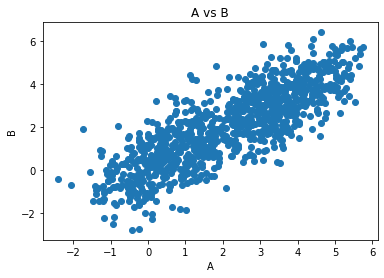

In [58]:
shuffles=10
L,A,B=LinearLABData()
#L,A,B=yeast_data(1,444)


In [172]:
A_shuffle=np.copy(A)
B_shuffle=np.copy(B)
#print("Original",B_shuffle)
loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
loss_list_third=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
true_LA=compute_loss(L,A,True)
true_LB=compute_loss(L,B,True)
#print("Next",B_shuffle)
true_loss_third=calculate_difference(L,A,B)
print(calculate_pvalue(true_LA,loss_list_LA))
print(calculate_pvalue(true_LB,loss_list_LB))
print(calculate_pvalue(true_loss_third,loss_list_third))

0.0
0.0
0.0


In [183]:
#checking whether the losses given using deep network and mle are the same 
loss_list_Bresidual


[1.6985755829609235,
 1.6997718774561918,
 1.6731068788334529,
 1.7067214226757852,
 1.6985168033472264,
 1.7012444635871748,
 1.6740837903396604,
 1.6920716605588682,
 1.6777053468812924,
 1.6658451078304697]

In [109]:
pickle_items=[loss_list_LA,loss_list_LB,loss_list_LindB_A,true_LA,true_LB,true_LindB_A]
file_name=str(shuffles)+"shuffles"+yeast_name+".pkl"
open_file = open(file_name, "wb")
pickle.dump(pickle_items, open_file)
open_file.close()


In [37]:
file_name="100shufflesyeast_1_444.pkl"
open_file = open(file_name, "rb")

loaded_list = pickle.load(open_file)

open_file.close()

In [41]:
loss_list_LA,loss_list_LB,loss_list_LindB_A,true_LA,true_LB,true_LindB_A=loaded_list